<a href="https://colab.research.google.com/github/pranav-joshi-iitgn/DigitalSystems/blob/main/DS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 187170903.33it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 82349214.02it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 179670876.98it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5460168.75it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



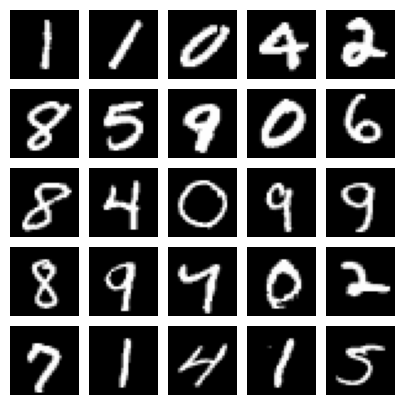

In [4]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [5]:
class Encoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [6]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

#     def forward(self, x):
#         mean, logvar = self.encode(x)
#         z = self.reparameterization(mean, logvar)
#         x_hat = self.decode(z)
#         return x_hat, mean, log_var

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [7]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(
        x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [9]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ",
              overall_loss/(batch_idx*batch_size))
    return overall_loss

In [10]:
train(model, optimizer, epochs=10, device=device)

	Epoch 1 	Average Loss:  181.37707319816883
	Epoch 2 	Average Loss:  158.9130936652233
	Epoch 3 	Average Loss:  153.87793987700854
	Epoch 4 	Average Loss:  151.30669739279006
	Epoch 5 	Average Loss:  149.3545911480071
	Epoch 6 	Average Loss:  147.96846457963792
	Epoch 7 	Average Loss:  146.89517953098914
	Epoch 8 	Average Loss:  146.18921786962645
	Epoch 9 	Average Loss:  145.27058386699187
	Epoch 10 	Average Loss:  144.63358453868426


8663551.713867188

In [11]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

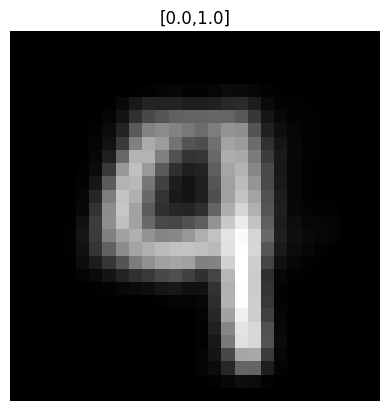

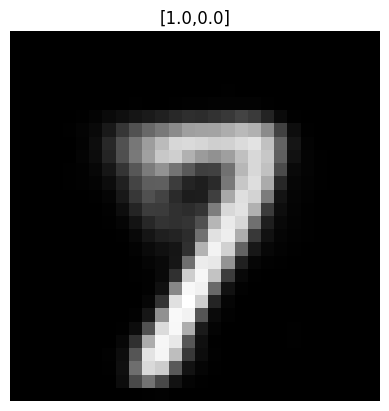

(None, None)

In [12]:
# img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [13]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

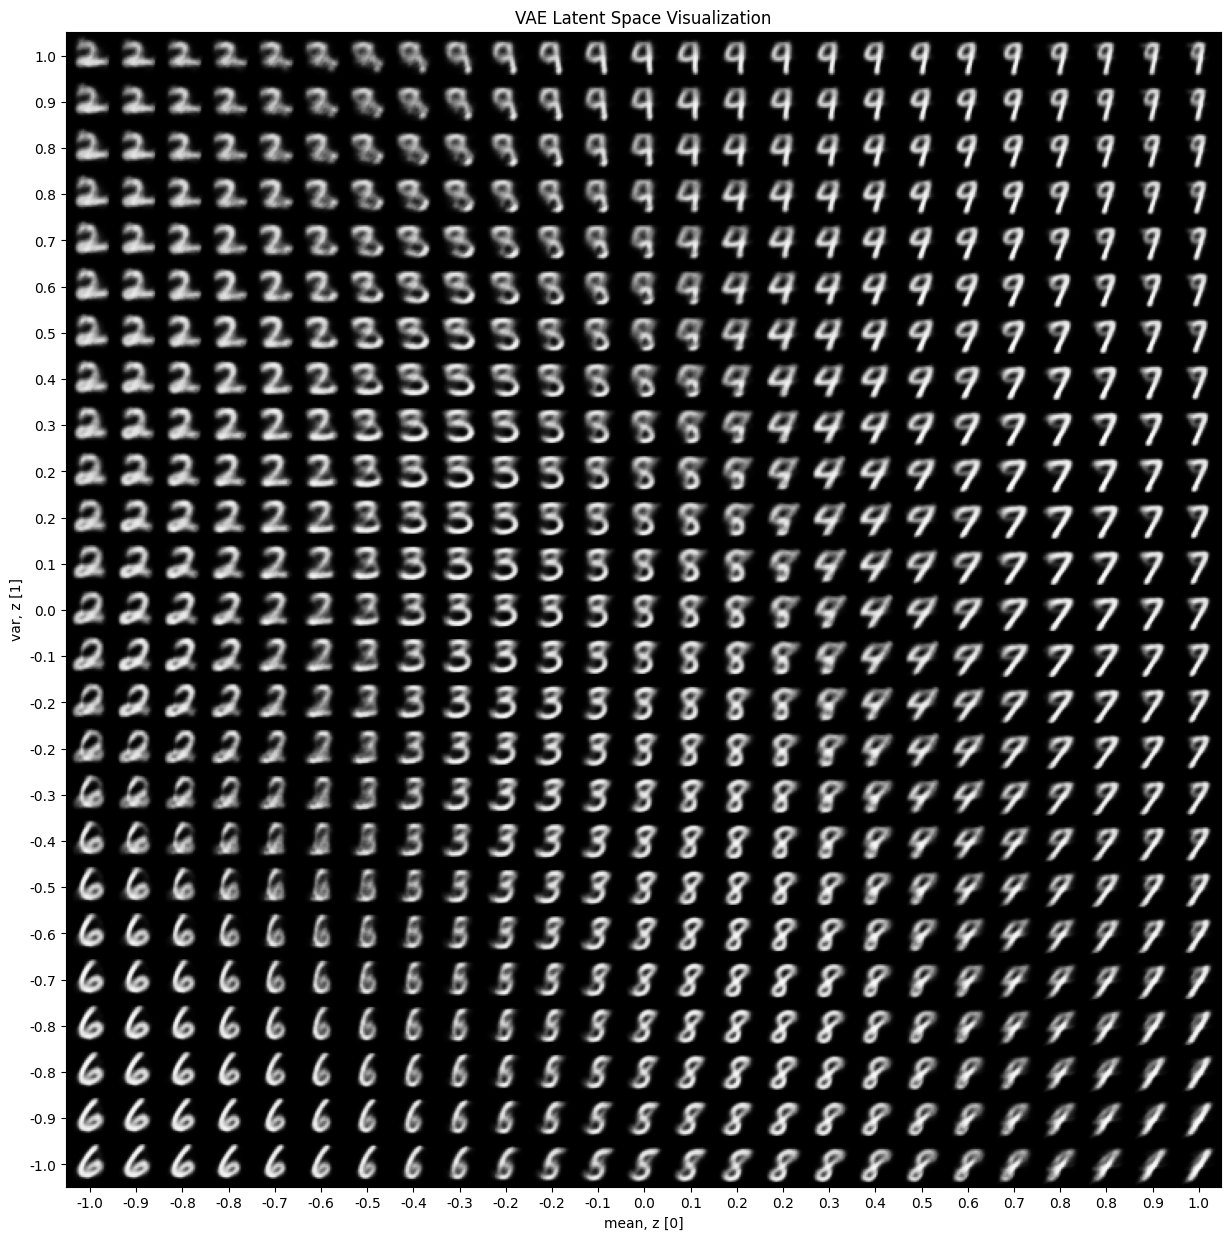

In [14]:
plot_latent_space(model, scale=1.0)

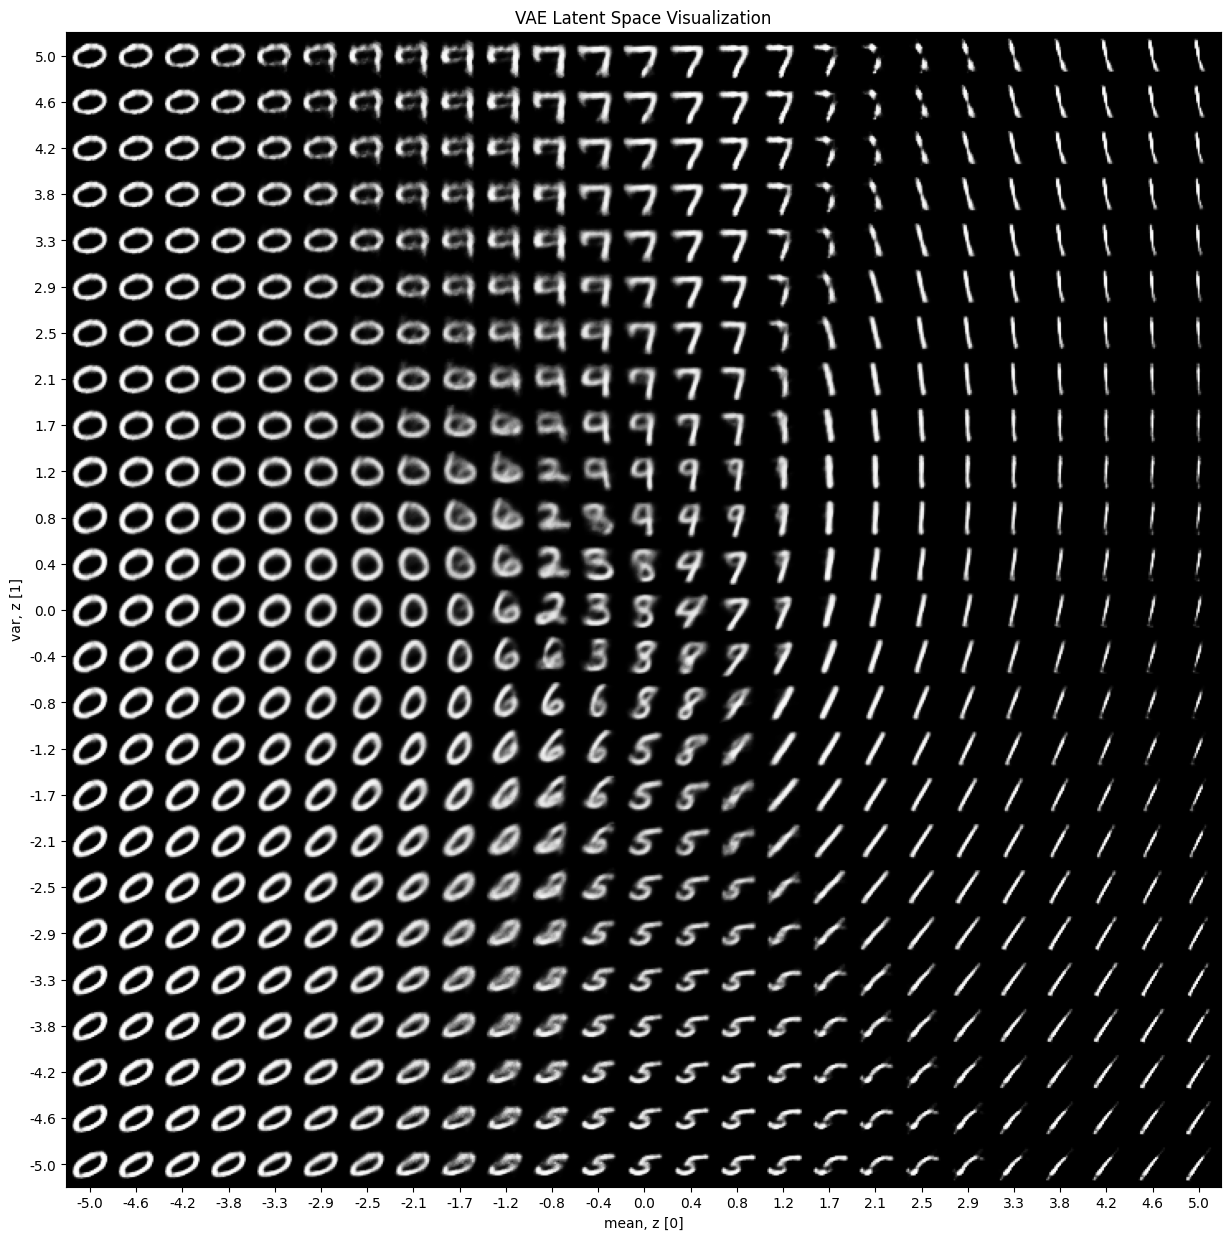

In [15]:
plot_latent_space(model, scale=5.0)

In [16]:
torch.save(model.state_dict(), './vae_model_state_dict.pth')

In [27]:
# Assuming decoder_model is your PyTorch decoder model
from os import write
weights_and_biases = []
for layer in [*model.modules()][1:]:
    if isinstance(layer, nn.Sequential):
      continue
    print(layer)
    if isinstance(layer, nn.Linear):
        w = layer.weight
        w = w.data
        w = w.cpu()
        w = w.numpy()
        b = layer.bias
        b = b.data
        b = b.cpu()
        b = b.numpy()
        weights_and_biases.append((w, b))
fixed_point_weights_and_biases = []
max_bits = 0
print()
S = 0
for weight, biase in weights_and_biases:
    fixed_point_weight = (weight * (2**15)).astype(np.int16)
    fixed_point_biase = (biase * (2**15)).astype(np.int16)
    fixed_point_weights_and_biases.append((fixed_point_weight, fixed_point_biase))
    m = np.max(np.log2(np.abs(fixed_point_weight)+1))
    if m > max_bits :
      max_bits = m
    m = np.max(np.log2(np.abs(fixed_point_biase)+1))
    if m > max_bits :
      max_bits = m
    s = (weight.shape[0]+1)*weight.shape[1]
    print(s,weight.shape)
    S += s
print("\nMaximum bits required : ",max_bits)
print("Total numbers needed to store : ",S)
s = []
for i,(w,b) in enumerate(fixed_point_weights_and_biases):
  s.extend([str(x) for x in b]) # d_in lines for b
  for row in w:
    s.extend([str(x) for x in row]) #c d_in lines for each row, d_out of which are there.
s = "\n".join(s)
file = open("W.txt",'w')
file.write(s)
file.close()

Linear(in_features=784, out_features=400, bias=True)
ReLU()
Linear(in_features=400, out_features=200, bias=True)
ReLU()
Linear(in_features=200, out_features=2, bias=True)
Linear(in_features=200, out_features=2, bias=True)
Linear(in_features=2, out_features=200, bias=True)
ReLU()
Linear(in_features=200, out_features=400, bias=True)
ReLU()
Linear(in_features=400, out_features=784, bias=True)
Sigmoid()

314384 (400, 784)
80400 (200, 400)
600 (2, 200)
600 (2, 200)
402 (200, 2)
80200 (400, 200)
314000 (784, 400)

Maximum bits required :  14.999516
Total numbers needed to store :  790586
